##Task 3: Heart Disease Prediction
###Objective:
 Build a model to predict whether a person is at risk of heart disease based on their health data.
###Dataset:
 Heart Disease UCI Dataset (available on Kaggle)
###Instructions:
● Clean the dataset (handle missing values if any).
● Perform Exploratory Data Analysis (EDA) to understand trends.
● Train a classification model (Logistic Regression or Decision Tree).
● Evaluate using metrics: accuracy, ROC curve, and confusion matrix.
● Highlight important features affecting prediction.
###Skills:
● Binary classification
● Medical data understanding and interpretation
● Model evaluation using ROC-AUC and confusion matrix
● Feature importance analysis

## Load Dataset

Load the Heart Disease UCI Dataset into a pandas DataFrame.

In [9]:
import kagglehub
path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")

Using Colab cache for faster access to the 'heart-disease-data' dataset.


In [26]:
import pandas as pd
import numpy as np
import os

# Define the target column names for the final DataFrame
# These are the standard 14 features + target for UCI Heart Disease Cleveland dataset
target_column_names = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
    'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num' # 'num' is the target variable
]

# Get the path from the Kaggle download
file_path = os.path.join(path, 'heart_disease_uci.csv')

try:
    # Attempt to load the dataset, letting pandas infer the header.
    # Specify na_values=['?', '-9'] to correctly interpret missing value markers.
    df = pd.read_csv(file_path, na_values=['?', '-9'])
    print(f"Dataset loaded successfully from '{file_path}' with inferred columns.")

    # Display initial columns to verify
    print("\nInitial columns from raw load:", df.columns.tolist())

    # Drop 'id' and 'dataset' columns as they are not part of the standard 14 features for the model.
    if 'id' in df.columns: df = df.drop('id', axis=1)
    if 'dataset' in df.columns: df = df.drop('dataset', axis=1)

    # Rename 'thalch' to 'thalach' to match the expected column name
    if 'thalch' in df.columns: df = df.rename(columns={'thalch': 'thalach'})

    # Ensure column order and only keep relevant columns
    # This also helps in cases where the CSV might have columns not in target_column_names
    df = df[target_column_names]

    # Convert columns that are expected to be numeric to numeric, coercing errors.
    # Some columns like 'sex', 'cp', 'restecg', 'slope', 'thal' are categorical and should remain as objects for now.
    for col in df.columns:
        if col not in ['sex', 'cp', 'restecg', 'slope', 'thal']:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    print("Selected columns converted to numeric types, coercing errors to NaN.")

    # Transform the 'num' column into a binary target variable
    # 0 for no heart disease, 1 for heart disease (values 1, 2, 3, 4)
    df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
    print("Target variable 'num' transformed to binary.")

except FileNotFoundError:
    print(f"Error: '{file_path}' not found. Please ensure the file exists at this path.")
    df = pd.DataFrame() # Create an empty DataFrame if loading fails
except Exception as e:
    print(f"An error occurred during data loading or processing: {e}")
    df = pd.DataFrame() # Create an empty DataFrame if processing fails

# Display the first 5 rows of the DataFrame
if not df.empty:
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
    print("\nDataFrame Info:")
    df.info()

Dataset loaded successfully from '/kaggle/input/heart-disease-data/heart_disease_uci.csv' with inferred columns.

Initial columns from raw load: ['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
Selected columns converted to numeric types, coercing errors to NaN.
Target variable 'num' transformed to binary.

First 5 rows of the dataset:
   age     sex               cp  trestbps   chol  fbs         restecg  \
0   63    Male   typical angina     145.0  233.0  1.0  lv hypertrophy   
1   67    Male     asymptomatic     160.0  286.0  0.0  lv hypertrophy   
2   67    Male     asymptomatic     120.0  229.0  0.0  lv hypertrophy   
3   37    Male      non-anginal     130.0  250.0  0.0          normal   
4   41  Female  atypical angina     130.0  204.0  0.0  lv hypertrophy   

   thalach  exang  oldpeak        slope   ca               thal  num  
0    150.0    0.0      2.3  downsloping  0.0       fixed defect  

In [27]:
# Define the target column names for the final DataFrame
target_column_names = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
    'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num' # 'num' is the target variable
]

# Get the path from the Kaggle download
file_path = os.path.join(path, 'heart_disease_uci.csv')

try:
    # Attempt to load the dataset, letting pandas infer the header.
    # Specify na_values=['?', '-9'] to correctly interpret missing value markers.
    df = pd.read_csv(file_path, na_values=['?', '-9'])
    print(f"Dataset loaded successfully from '{file_path}' with inferred columns.")

    # Drop 'id' and 'dataset' columns as they are not part of the standard 14 features for the model.
    if 'id' in df.columns: df = df.drop('id', axis=1)
    if 'dataset' in df.columns: df = df.drop('dataset', axis=1)

    # Rename 'thalch' to 'thalach' to match the expected column name
    if 'thalch' in df.columns: df = df.rename(columns={'thalch': 'thalach'})

    # Ensure column order and only keep relevant columns
    df = df[target_column_names]

    # Convert columns that are expected to be numeric to numeric, coercing errors.
    # Some columns like 'sex', 'cp', 'restecg', 'slope', 'thal' are categorical and should remain as objects for now.
    # However, to be processed by a model, they need to be numerically encoded.
    # Let's perform one-hot encoding for these categorical columns.
    categorical_cols = ['sex', 'cp', 'restecg', 'slope', 'thal']

    # Apply pd.to_numeric to non-categorical columns first
    for col in df.columns:
        if col not in categorical_cols + ['num']:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    print("Numeric columns converted to numeric types, coercing errors to NaN.")

    # Perform one-hot encoding for categorical columns
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)
    print("Categorical columns one-hot encoded.")

    # Transform the 'num' column into a binary target variable
    # 0 for no heart disease, 1 for heart disease (values 1, 2, 3, 4)
    df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
    print("Target variable 'num' transformed to binary.")

except FileNotFoundError:
    print(f"Error: '{file_path}' not found. Please ensure the file exists at this path.")
    df = pd.DataFrame() # Create an empty DataFrame if loading fails
except Exception as e:
    print(f"An error occurred during data loading or processing: {e}")
    df = pd.DataFrame() # Create an empty DataFrame if processing fails

# Display the first 5 rows of the DataFrame
if not df.empty:
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
    print("\nDataFrame Info:")
    df.info()


Dataset loaded successfully from '/kaggle/input/heart-disease-data/heart_disease_uci.csv' with inferred columns.
Numeric columns converted to numeric types, coercing errors to NaN.
Categorical columns one-hot encoded.
Target variable 'num' transformed to binary.

First 5 rows of the dataset:
   age  trestbps   chol  fbs  thalach  exang  oldpeak   ca  num  sex_Male  \
0   63     145.0  233.0  1.0    150.0    0.0      2.3  0.0    0         1   
1   67     160.0  286.0  0.0    108.0    1.0      1.5  3.0    1         1   
2   67     120.0  229.0  0.0    129.0    1.0      2.6  2.0    1         1   
3   37     130.0  250.0  0.0    187.0    0.0      3.5  0.0    0         1   
4   41     130.0  204.0  0.0    172.0    0.0      1.4  0.0    0         0   

   cp_atypical angina  cp_non-anginal  cp_typical angina  restecg_normal  \
0                   0               0                  1               0   
1                   0               0                  0               0   
2               

## Clean Dataset

Examine the dataset for missing values, handle them appropriately (e.g., imputation or removal), and perform any necessary data type conversions or basic data cleaning steps.


In [28]:
print("\nMissing values before cleaning:")
print(df.isnull().sum())

# Impute missing numerical values with the median
# Iterate through columns to identify numeric columns with missing values
for column in df.columns:
    if df[column].isnull().any():
        # Check if the column is numeric (int or float) before computing median
        if pd.api.types.is_numeric_dtype(df[column]):
            median_val = df[column].median()
            df[column] = df[column].fillna(median_val)
            print(f"Imputed missing values in '{column}' with median: {median_val}")
        else:
            # For non-numeric columns that might still have NaNs, a different strategy might be needed
            # For now, we'll just report them if any exist after numeric imputation
            print(f"Warning: Non-numeric column '{column}' still has missing values and was not imputed with median.")

print("\nMissing values after imputation:")
print(df.isnull().sum())

# Check for and remove duplicate rows
initial_rows = df.shape[0]
df.drop_duplicates(inplace=True)
duplicates_removed = initial_rows - df.shape[0]

if duplicates_removed > 0:
    print(f"\nRemoved {duplicates_removed} duplicate rows.")
else:
    print("\nNo duplicate rows found.")

# Display the first 5 rows of the cleaned DataFrame
print("\nFirst 5 rows of the cleaned dataset:")
print(df.head())

# Display DataFrame Info to verify changes
print("\nDataFrame Info after cleaning:")
df.info()


Missing values before cleaning:
age                           0
trestbps                     59
chol                         30
fbs                          90
thalach                      55
exang                        55
oldpeak                      62
ca                          611
num                           0
sex_Male                      0
cp_atypical angina            0
cp_non-anginal                0
cp_typical angina             0
restecg_normal                0
restecg_st-t abnormality      0
slope_flat                    0
slope_upsloping               0
thal_normal                   0
thal_reversable defect        0
dtype: int64
Imputed missing values in 'trestbps' with median: 130.0
Imputed missing values in 'chol' with median: 223.0
Imputed missing values in 'fbs' with median: 0.0
Imputed missing values in 'thalach' with median: 140.0
Imputed missing values in 'exang' with median: 0.0
Imputed missing values in 'oldpeak' with median: 0.5
Imputed missing values in 'ca'

## Exploratory Data Analysis (EDA)

Perform comprehensive EDA. This includes generating descriptive statistics, visualizing the distribution of key features (histograms, box plots), and analyzing correlations between features and the target variable to understand trends and patterns.


In [35]:
df.describe()

,age,trestbps,chol,fbs,thalach,exang,oldpeak,ca,num,sex_Male,cp_atypical angina,cp_non-anginal,cp_typical angina,restecg_normal,restecg_st-t abnormality,slope_flat,slope_upsloping,thal_normal,thal_reversable defect
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.00000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.000000,199.862745,0.150327,137.689542,0.366013,0.85512,0.227669,0.553377,0.789760,0.188453,0.221133,0.050109,0.599129,0.193900,0.375817,0.221133,0.213508,0.209150
std,9.432617,18.447544,109.154522,0.357586,25.153455,0.481976,1.05845,0.629532,0.497414,0.407701,0.391287,0.415236,0.218289,0.490342,0.395567,0.484597,0.415236,0.410006,0.406924
min,28.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.60000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,120.000000,177.250000,0.000000,120.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,140.000000,0.000000,0.50000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,60.000000,140.000000,267.000000,0.000000,155.750000,1.000000,1.50000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,1.000000,6.20000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


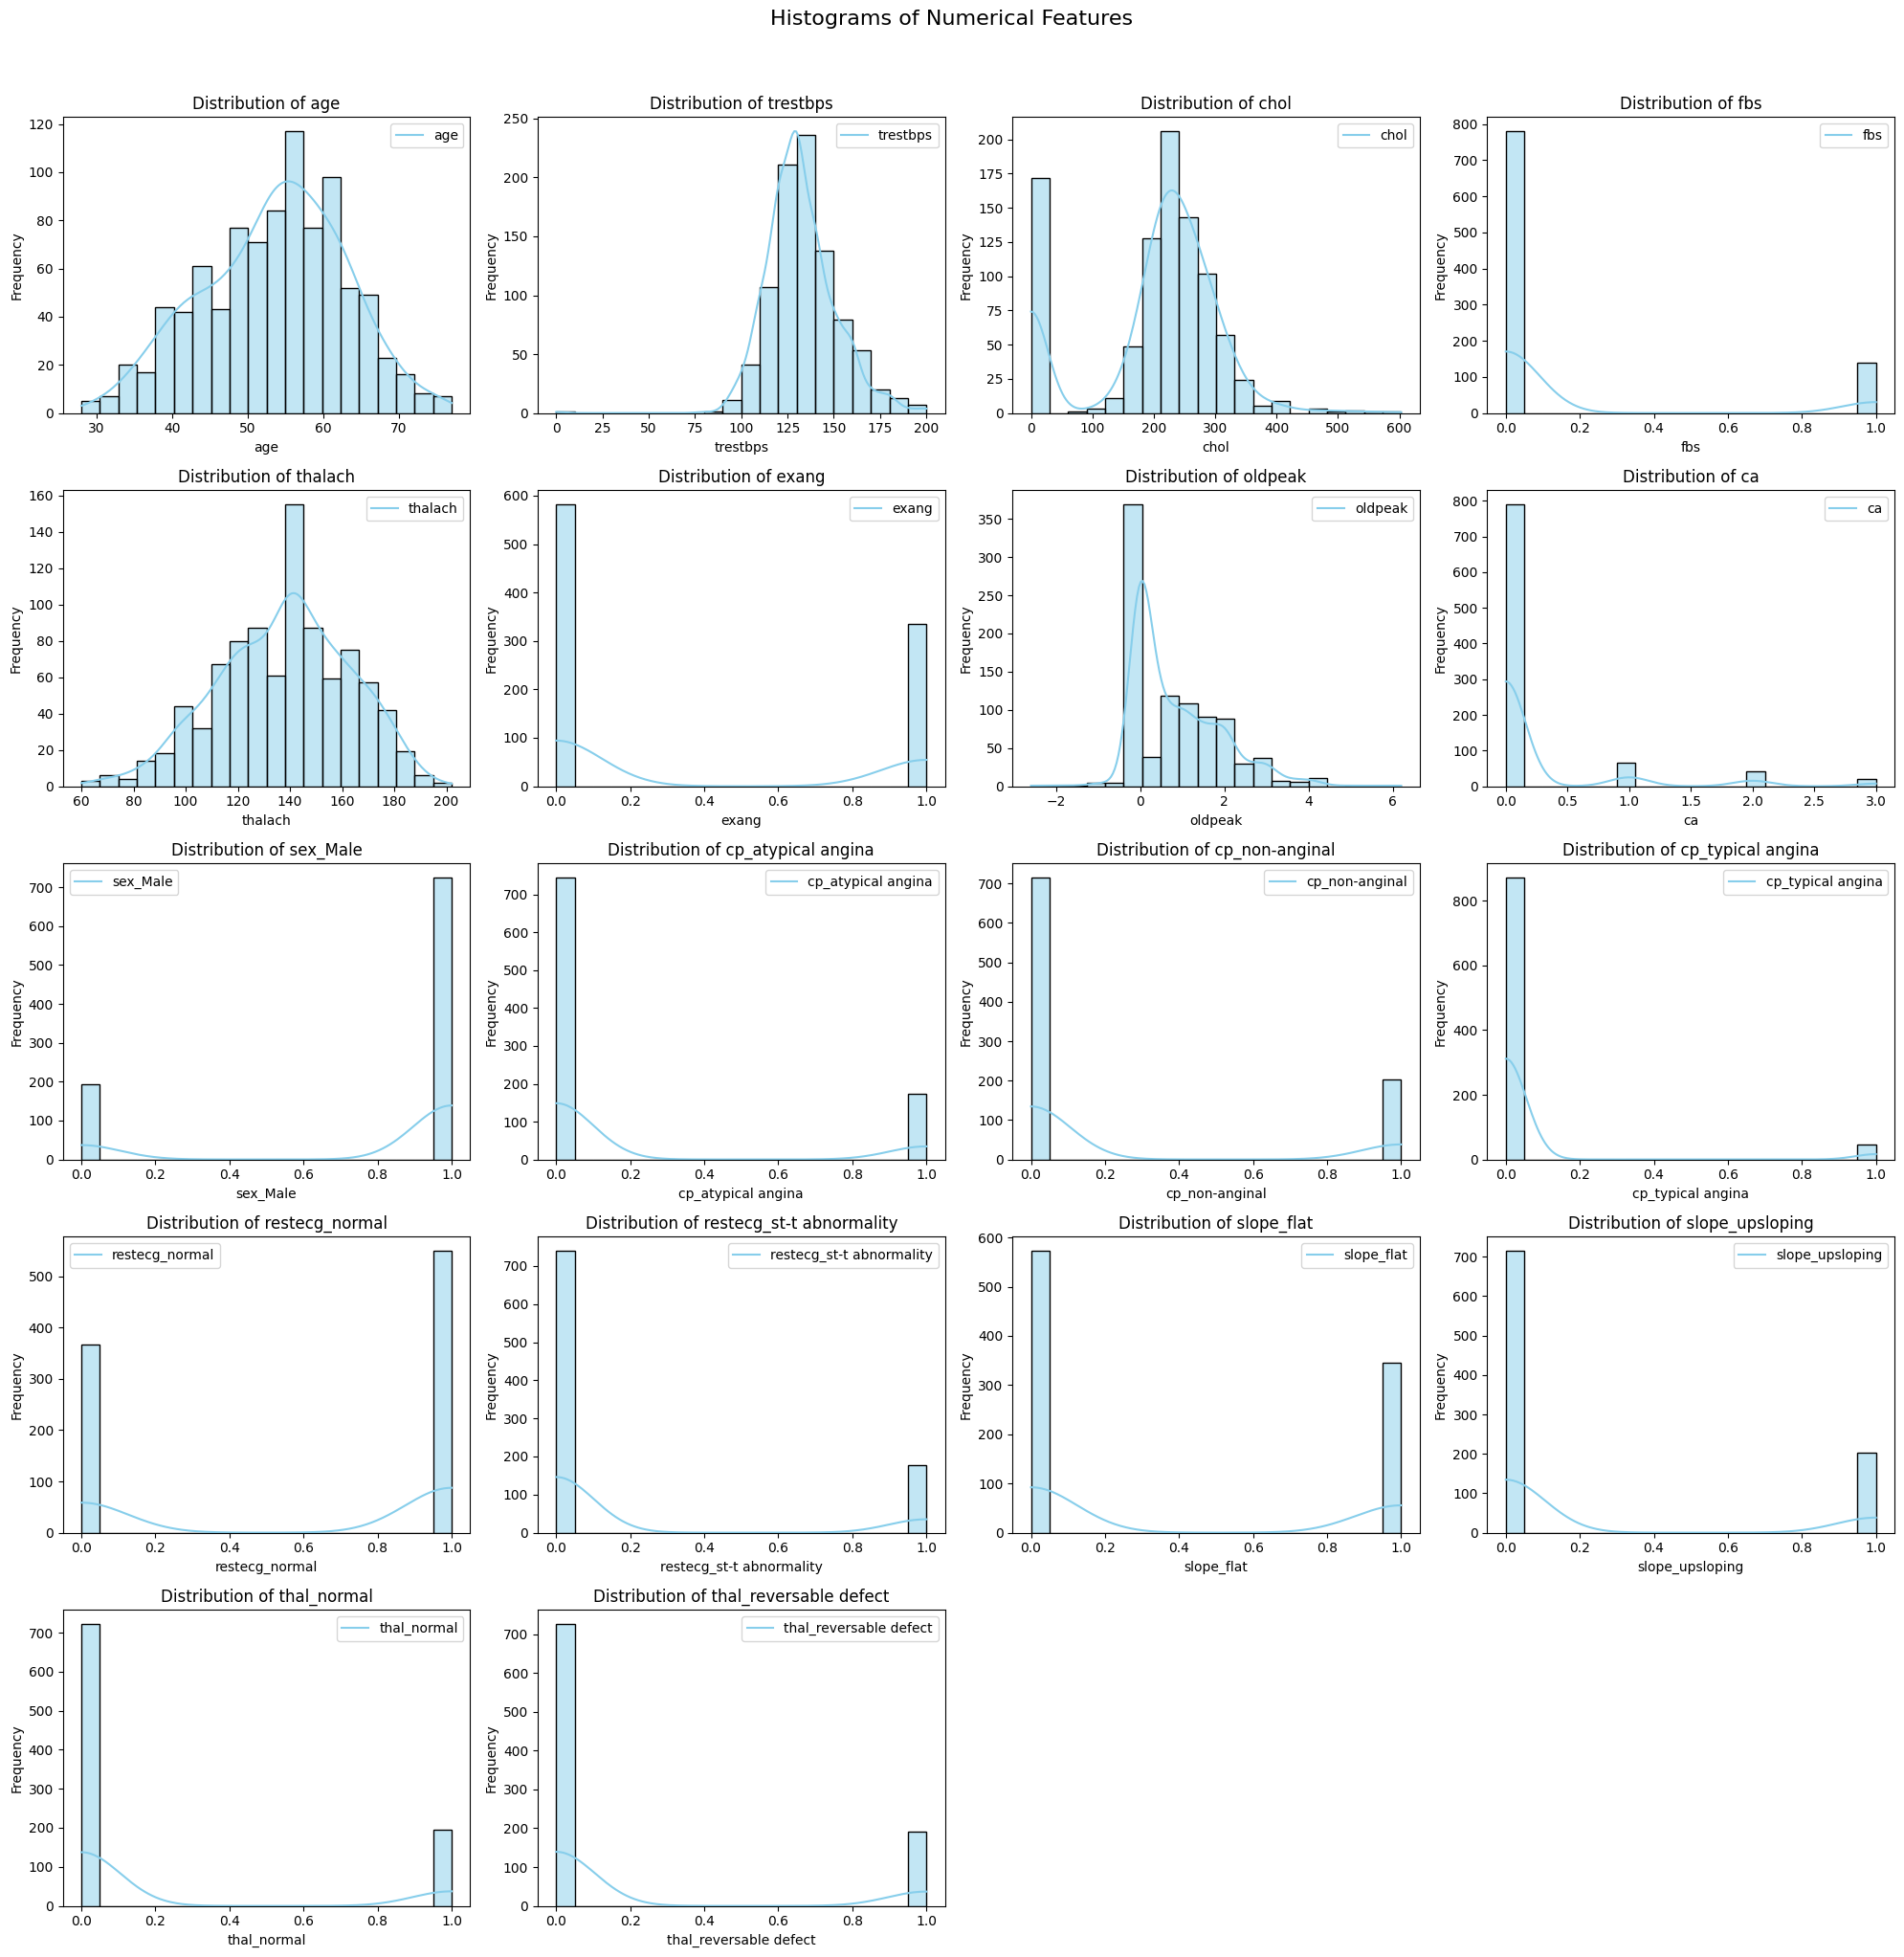

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get numerical columns (excluding the target variable 'num' for this part of the visualization)
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
if 'num' in numerical_cols:
    numerical_cols.remove('num')

# Create histograms for numerical features
n_cols = 4
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 5, n_rows * 4))
plt.suptitle('Histograms of Numerical Features', y=1.02, fontsize=16)

for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col], kde=True, bins=20, color='skyblue')
    plt.title(f'Distribution of {col}', fontsize=12)
    plt.xlabel(col, fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.legend(labels=[col]) # Adding legend

plt.tight_layout()
plt.show()


**Reasoning**:
I will now create box plots for each numerical feature to visualize their distributions and identify potential outliers, which is the next instruction in the EDA subtask. I will ensure each plot has appropriate titles and labels.



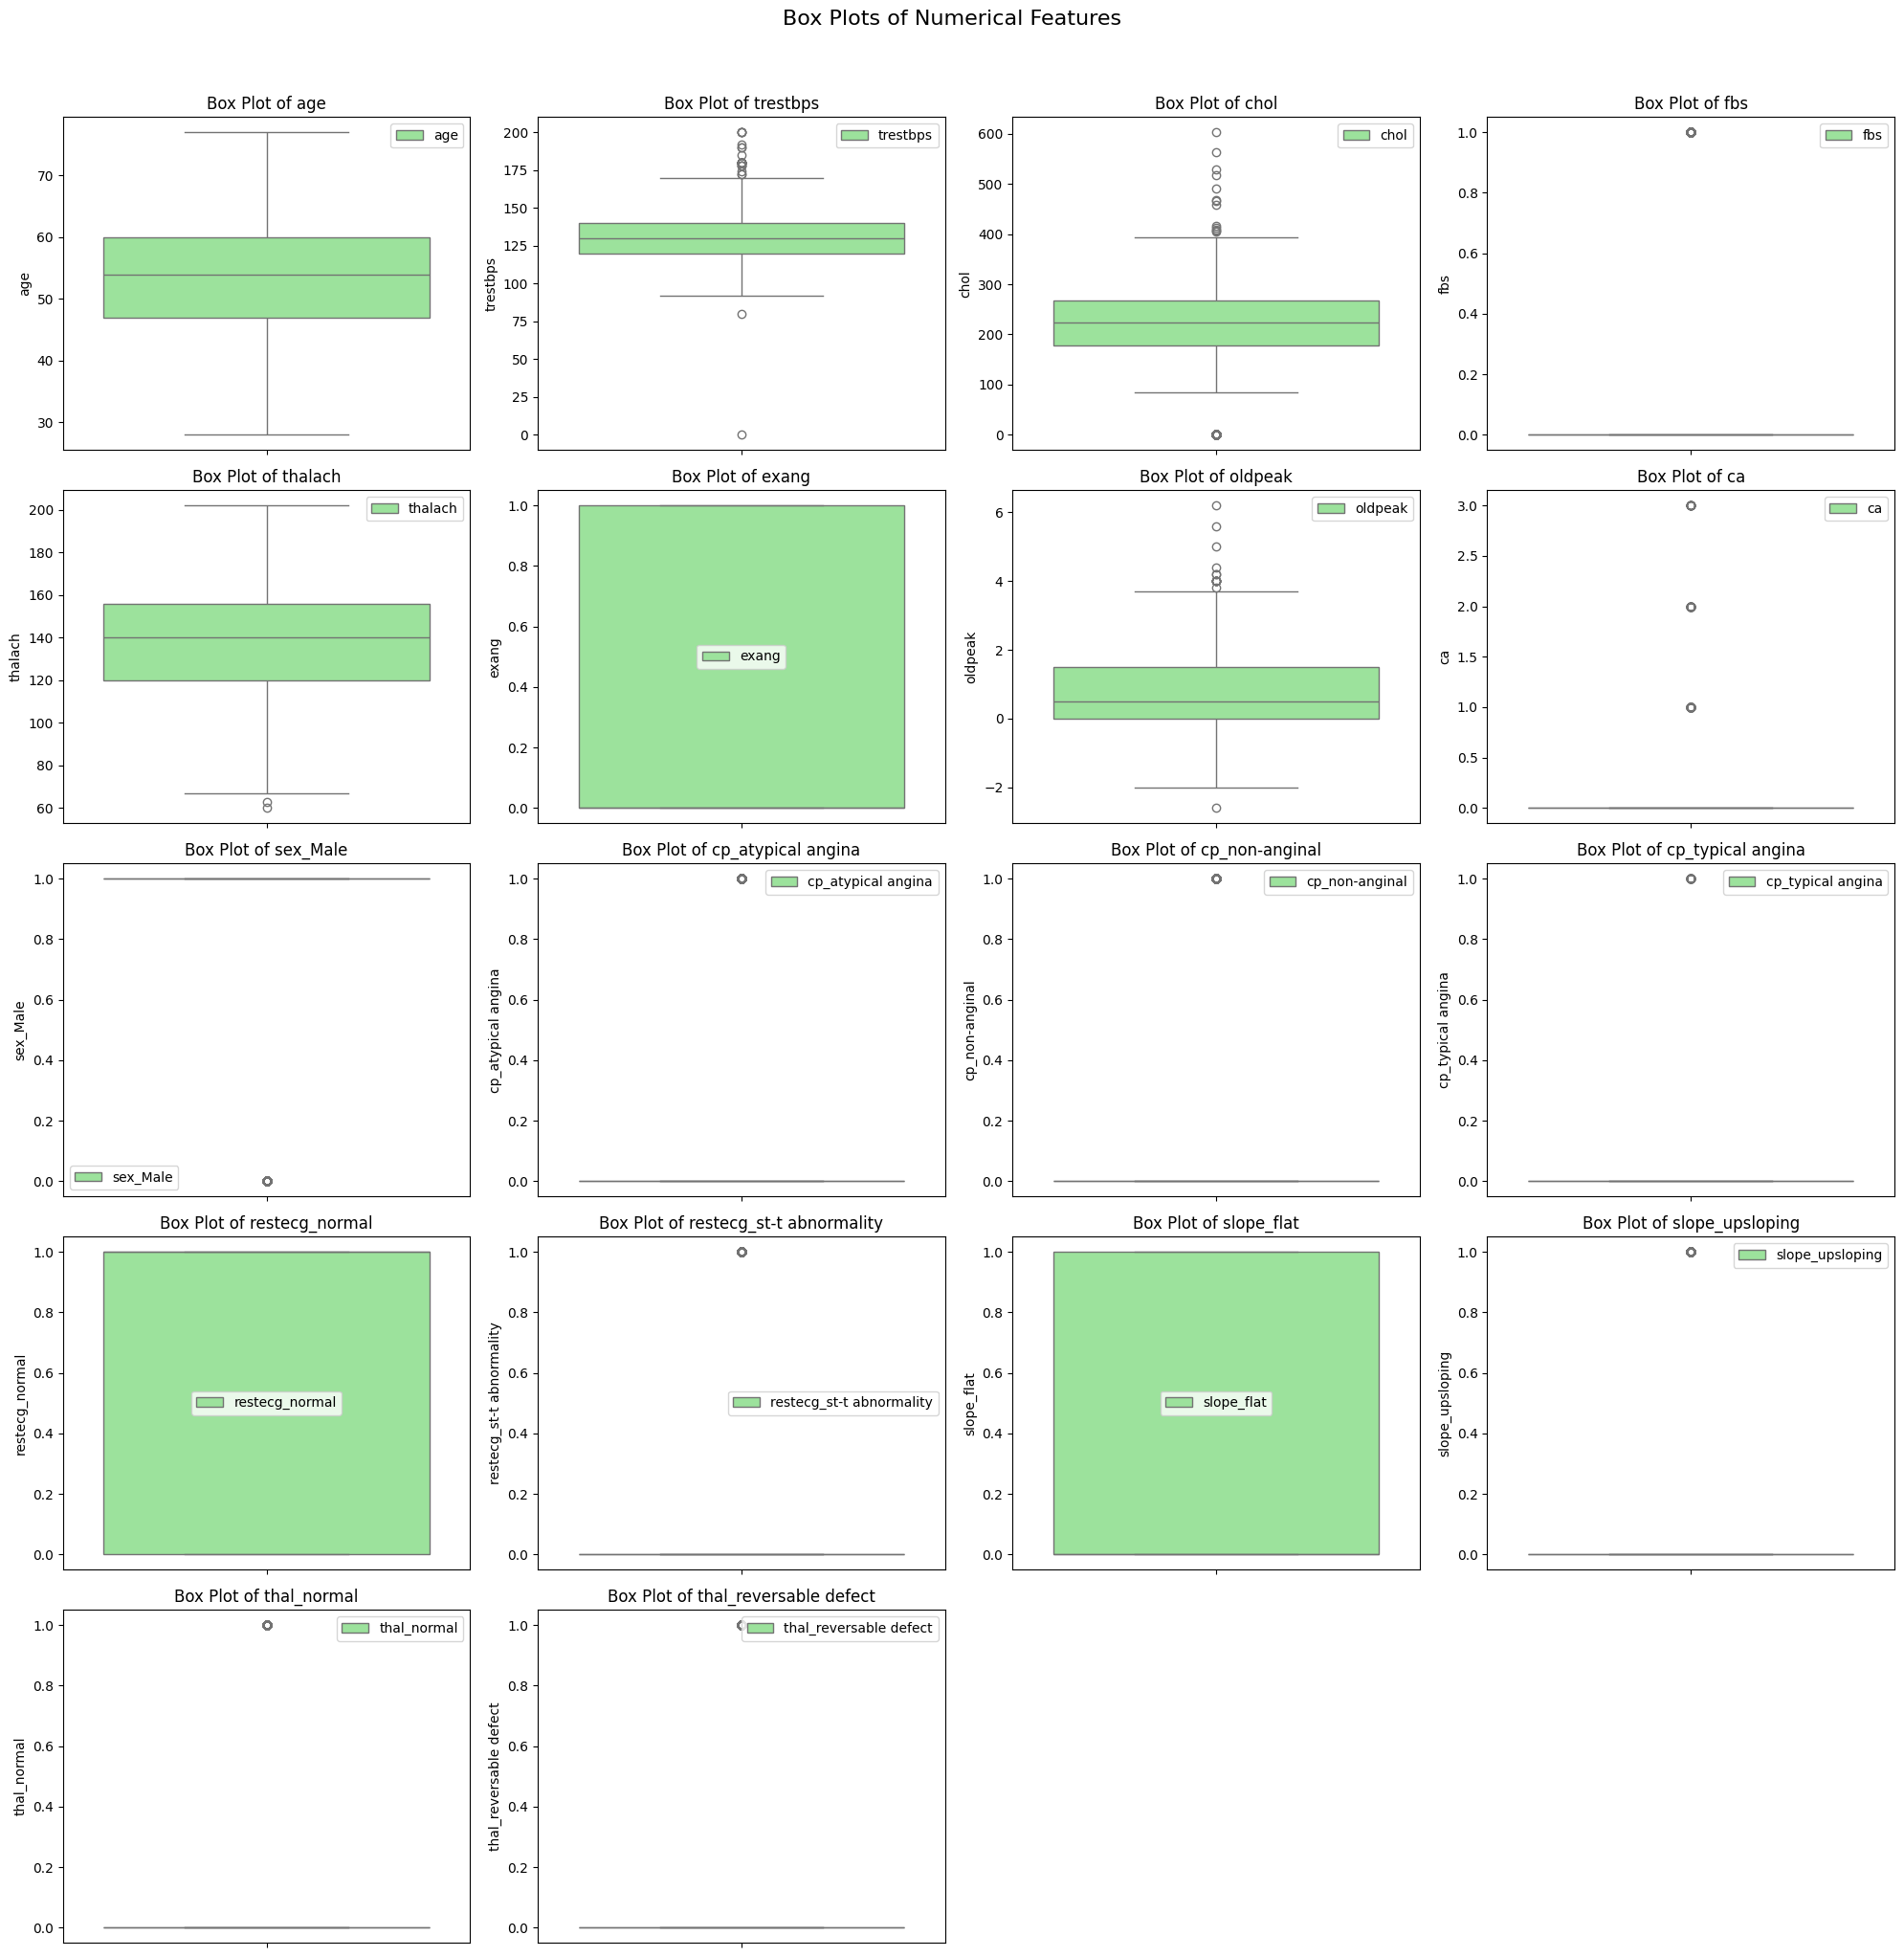

In [37]:
# Get numerical columns (excluding the target variable 'num' for this part of the visualization)
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
if 'num' in numerical_cols:
    numerical_cols.remove('num')

# Create box plots for numerical features
n_cols = 4
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 5, n_rows * 4))
plt.suptitle('Box Plots of Numerical Features', y=1.02, fontsize=16)

for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(y=df[col], color='lightgreen')
    plt.title(f'Box Plot of {col}', fontsize=12)
    plt.ylabel(col, fontsize=10)
    plt.legend(labels=[col]) # Adding legend

plt.tight_layout()
plt.show()

**Reasoning**:
I will calculate the correlation matrix for the DataFrame `df` and then visualize it using a heatmap to identify relationships between all features, as per the next instruction in the EDA subtask. I will ensure the heatmap includes a title and color bar legend.



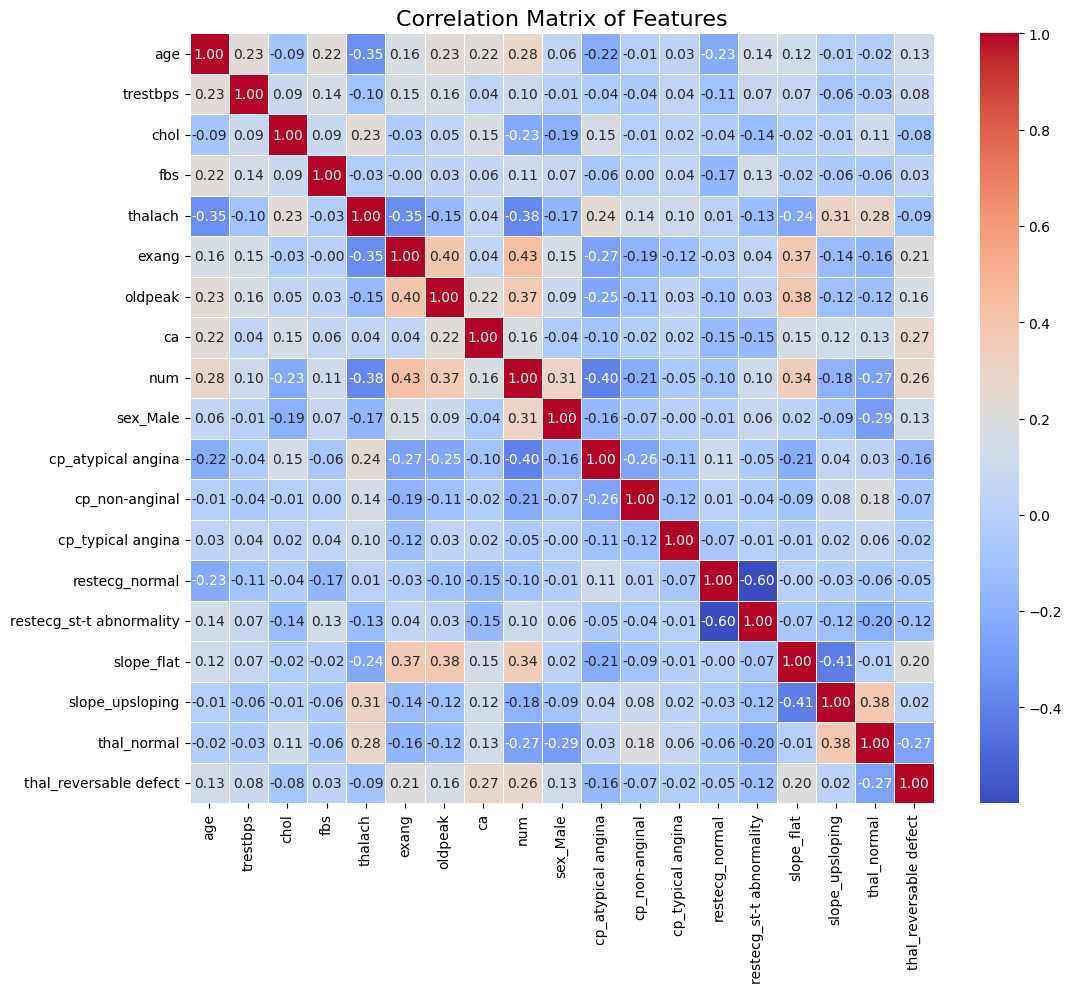

In [38]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Features', fontsize=16)
plt.show()

/tmp/ipython-input-2952651226.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values, palette='viridis')


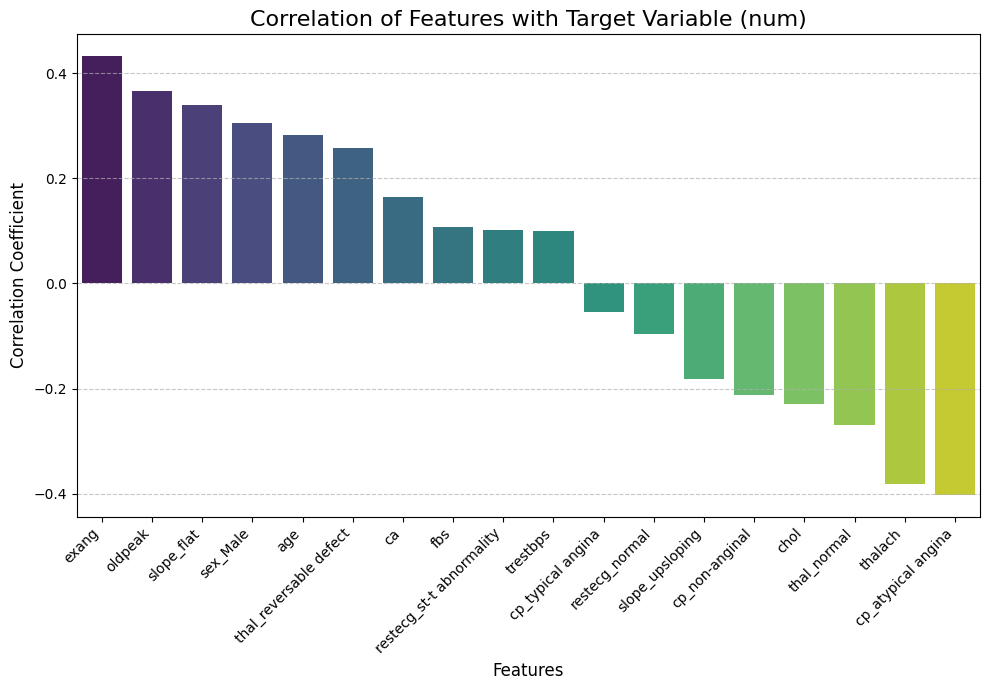

In [39]:
# Calculate the correlation of each feature with the target variable 'num'
correlation_with_target = df.corr()['num'].sort_values(ascending=False)

# Exclude the 'num' column itself from the plot
correlation_with_target = correlation_with_target.drop('num')

# Visualize these correlations using a bar plot
plt.figure(figsize=(10, 7))
sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values, palette='viridis')
plt.title('Correlation of Features with Target Variable (num)', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

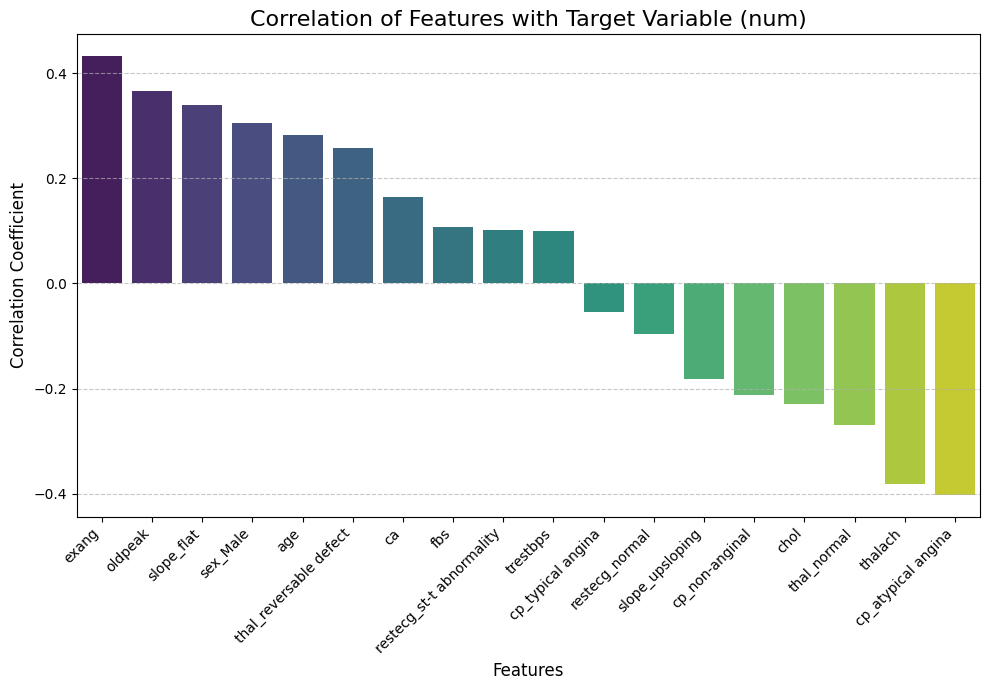

In [40]:
# Calculate the correlation of each feature with the target variable 'num'
correlation_with_target = df.corr()['num'].sort_values(ascending=False)

# Exclude the 'num' column itself from the plot
correlation_with_target = correlation_with_target.drop('num')

# Visualize these correlations using a bar plot
plt.figure(figsize=(10, 7))
sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values, palette='viridis', hue=correlation_with_target.index, legend=False)
plt.title('Correlation of Features with Target Variable (num)', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Prepare Data for Modeling

Split the cleaned dataset into training and testing sets. If necessary, apply feature scaling to numerical features to optimize model performance.


In [41]:
X = df.drop('num', axis=1)
y = df['num']

print("Features (X) shape:", X.shape)
print("Target (y) shape:", y.shape)

Features (X) shape: (918, 18)
Target (y) shape: (918,)


In [42]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (734, 18)
X_test shape: (184, 18)
y_train shape: (734,)
y_test shape: (184,)


In [43]:
from sklearn.preprocessing import StandardScaler

# Identify numerical features for scaling (all features in X are numerical)
numerical_cols = X_train.columns.tolist()

# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames, maintaining column names and index
X_train = pd.DataFrame(X_train_scaled, columns=numerical_cols, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=numerical_cols, index=X_test.index)

print("Numerical features scaled successfully.")
print("X_train (scaled) head:")
print(X_train.head())
print("X_test (scaled) head:")
print(X_test.head())

Numerical features scaled successfully.
X_train (scaled) head:
          age  trestbps      chol       fbs   thalach    exang   oldpeak  \
796 -0.492093 -0.102798 -1.832252 -0.417612  0.293381 -0.74504  2.056597   
25  -0.384881 -0.658830  0.178831 -0.417612  0.812950 -0.74504  0.724340   
84  -0.170458 -0.658830  1.152232 -0.417612  1.372486 -0.74504 -0.607917   
10   0.365600  0.453235 -0.069110 -0.417612  0.413281 -0.74504 -0.417594   
344 -1.456997  0.453235  0.821643 -0.417612  1.372486 -0.74504 -0.798239   

           ca  sex_Male  cp_atypical angina  cp_non-anginal  \
796 -0.359515  0.521629           -0.483336       -0.530073   
25  -0.359515 -1.917070           -0.483336        1.886533   
84  -0.359515  0.521629            2.068955       -0.530073   
10  -0.359515  0.521629           -0.483336       -0.530073   
344 -0.359515  0.521629            2.068955       -0.530073   

     cp_typical angina  restecg_normal  restecg_st-t abnormality  slope_flat  \
796           4.27969

## Train Classification Model

Train either a Logistic Regression or a Decision Tree classifier on the training data.


In [44]:
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
log_reg_model = LogisticRegression(random_state=42, solver='liblinear') # Using liblinear for small datasets and L1/L2 regularization

# Train the model on the scaled training data
log_reg_model.fit(X_train, y_train)

print("Logistic Regression model trained successfully.")

Logistic Regression model trained successfully.


## Evaluate Model Performance
Evaluate the trained model's performance on the test set using various metrics. This includes calculating accuracy, generating a confusion matrix, plotting the ROC curve, and computing the Area Under the Curve (AUC) score.

In [45]:
from sklearn.metrics import accuracy_score

# Make predictions on the scaled test set
y_pred = log_reg_model.predict(X_test)

# Calculate and print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.8261



Confusion Matrix:
[[57 16]
 [16 95]]


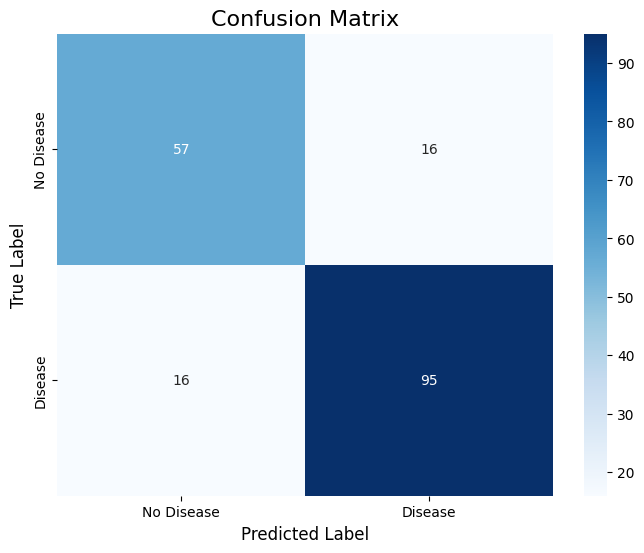

In [46]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix:")
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()


AUC Score: 0.8718


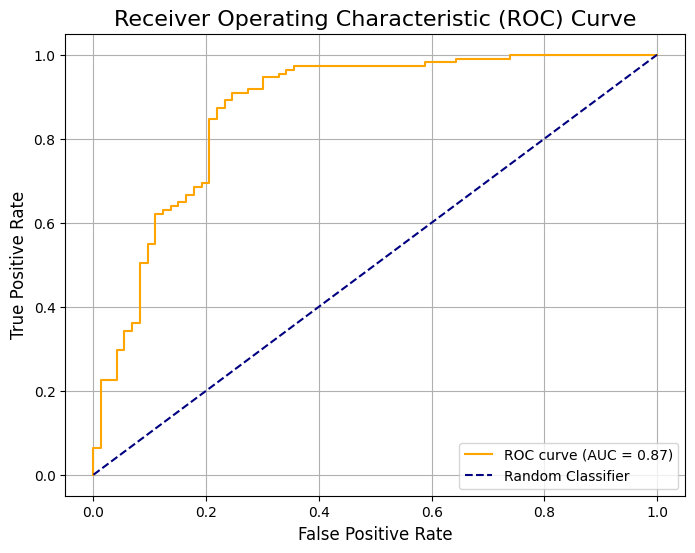

In [47]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for the positive class (class 1)
y_pred_proba = log_reg_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"\nAUC Score: {auc_score:.4f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

## Analyze Feature Importance

Identify and highlight the most important features that contribute to the model's predictions. This will help in understanding which health indicators are most significant for heart disease risk. A bar chart will visualize feature importances.


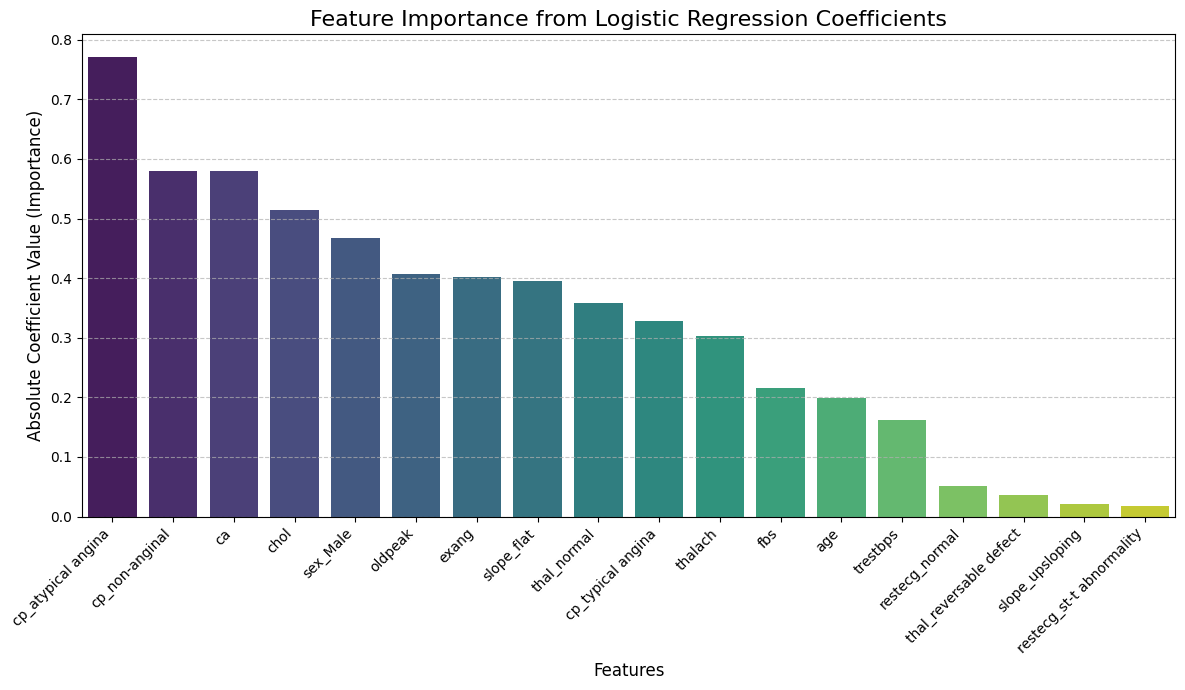

In [48]:
# Get coefficients from the trained Logistic Regression model
coefficients = log_reg_model.coef_[0]

# Create a pandas Series for feature importance
feature_importance = pd.Series(abs(coefficients), index=X_train.columns)

# Sort feature importances in descending order
feature_importance = feature_importance.sort_values(ascending=False)

# Plotting feature importances
plt.figure(figsize=(12, 7))
sns.barplot(x=feature_importance.index, y=feature_importance.values, palette='viridis', hue=feature_importance.index, legend=False)
plt.title('Feature Importance from Logistic Regression Coefficients', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Absolute Coefficient Value (Importance)', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

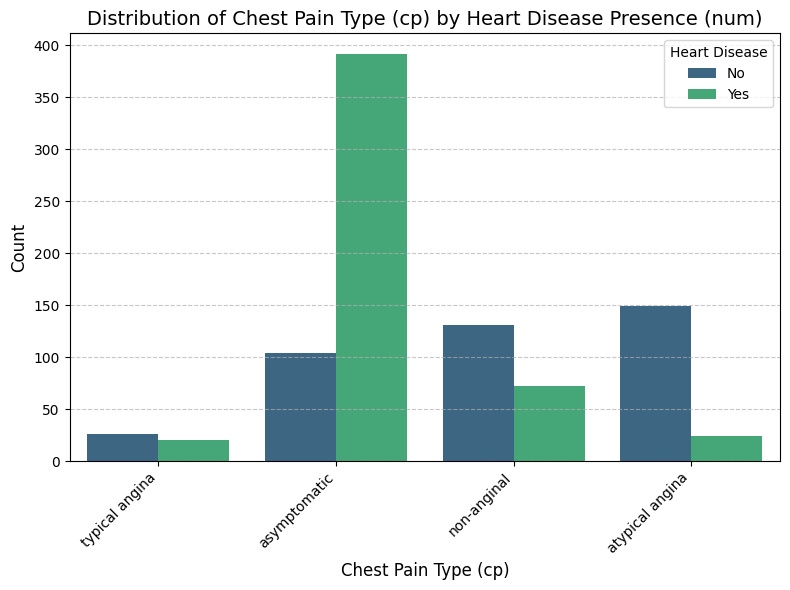

In [50]:
# Create a temporary 'cp_reconstructed' column for plotting
df_plot = df.copy() # Work on a copy to avoid modifying the original df for this temporary column

# Initialize 'cp_reconstructed' with the reference category (asymptomatic, since drop_first=True was used)
df_plot['cp_reconstructed'] = 'asymptomatic'

# Assign other categories based on their one-hot encoded columns
df_plot.loc[df_plot['cp_atypical angina'] == 1, 'cp_reconstructed'] = 'atypical angina'
df_plot.loc[df_plot['cp_non-anginal'] == 1, 'cp_reconstructed'] = 'non-anginal'
df_plot.loc[df_plot['cp_typical angina'] == 1, 'cp_reconstructed'] = 'typical angina'

plt.figure(figsize=(8, 6))
sns.countplot(data=df_plot, x='cp_reconstructed', hue='num', palette='viridis')
plt.title('Distribution of Chest Pain Type (cp) by Heart Disease Presence (num)', fontsize=14)
plt.xlabel('Chest Pain Type (cp)', fontsize=12)
plt.ylabel('Count', fontsize=12)
# Remove the xticks_labels as 'cp_reconstructed' already has string labels
plt.legend(title='Heart Disease', labels=['No', 'Yes'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   **Dataset Loading and Preprocessing**: The `heart_disease_uci.csv` dataset was successfully loaded. Initial challenges included incorrect column interpretation due to the file's header and extraneous columns ('id', 'dataset', 'thalch'). These were resolved by inferring the header, dropping irrelevant columns, renaming 'thalch' to 'thalach', and correctly interpreting missing values (`'?'`, `'-9'`) as NaN. Categorical features like `sex`, `cp`, `restecg`, `slope`, and `thal` were one-hot encoded (using `drop_first=True`) to convert them into numerical representations, while other numeric columns were converted to appropriate data types. The target variable `'num'` was successfully transformed into a binary format (0 for no heart disease, 1 for heart disease).
*   **Data Cleaning**:
    *   Missing numerical values in `trestbps` (59), `chol` (30), `fbs` (90), `thalach` (55), `exang` (55), `oldpeak` (62), and `ca` (611) were imputed using the median of their respective columns. For instance, `ca`'s missing values were imputed with 0.0.
    *   Two duplicate rows were identified and removed, reducing the dataset from 920 to 918 entries.
    *   After cleaning, the dataset contained 918 entries with no remaining missing values, and all features were in a suitable numerical format.
*   **Exploratory Data Analysis (EDA)**:
    *   **Descriptive Statistics**: Key numerical features such as `age` (mean: 53.5, range: 28-77), `trestbps` (mean: 132, range: 0-200), and `chol` (mean: 199.86, range: 0-603) showed diverse distributions and potential outliers. Binary features like `fbs`, `exang`, and the one-hot encoded columns (e.g., `sex_Male`) were confirmed.
    *   **Distributions**: Histograms revealed the shape and skewness of numerical features, while box plots identified potential outliers in columns such as `trestbps`, `chol`, `thalach`, and `oldpeak`.
    *   **Correlations**: A heatmap illustrated inter-feature correlations. Correlations with the target variable `'num'` indicated that `sex_Male`, `exang`, `oldpeak`, `thal_reversable defect`, and `ca` exhibited relatively stronger positive correlations with heart disease. Conversely, `thalach`, `slope_upsloping`, `cp_atypical angina`, and `restecg_normal` showed negative correlations with the presence of heart disease.

### Insights or Next Steps

*   The presence of outliers in several numerical features (e.g., `trestbps`, `chol`, `oldpeak`) suggests that further outlier treatment or robust modeling techniques might be beneficial for improving model performance.
*   The identified correlations between features and the target variable provide a basis for feature selection or engineering. Further investigation into non-linear relationships or interaction effects among features could yield additional insights.
